# Batch Normalization

# Accelerating Deep Network Training by Reducing Internal Covariate Shift

(Ioffe and Szegedy 2015) - Ioffe, Sergey, and Christian Szegedy. 2015. “Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift.” https://arxiv.org/abs/1502.03167 (September 7, 2021).


## Introduction

Deep neural netowrks most often suffer from a training complication where the distribution of the input data changes. As the data moves down stream through the hidden layers, the distribution of the data going into the hidden layers changes since the parameters from the previous layers are changing. This change in data distribution slows down the training process by requiring *lower learning rates and careful parameter initialization, and makes it notoriously hard to train models with saturating nonlinearities*. The change in the distribution of the data (or network activations) is known as **Internal Co-variate Shift**. 

Formally, **covariate shift** is defined as a *change in the distribution of a function’s domain*. Informally, it’s when your inputs change on you, and your algorithm can’t deal with it. [[Ref-8]](https://gab41.lab41.org/batch-normalization-what-the-hey-d480039a9e3b)

The change in the distribution of the input variables present in the training and the test data. It is termed as **Internal** since the data distribution here is referred for the **hidden layers**.

Covariate shift is know to slow down training since the layers first need to adapt to the newer distribution everytime before applying the convolutional transformations.

The BatchNorm paper propose address this issue by - ***normalizing the input by dividing the dataset into mini-batches and perform normalization on per batch***. **Mini-batches** as opposed to using the single data item as a time in known to have several advantages - 

- The gradient of loss over a mini batch is an estimate of the gradient over the fll training set. This estimate is known to get closer to hat of the full training set with increase in the batch size.

- Computation is a batch could utilize the parallel processing capabilities as supported by the hardware.

The idea of covariate shift can be extended to a sub-system of hidden layers block of the network as well. Consider a network computing - <br>
**l = F<sub>2</sub>(F<sub>1</sub>(μ, θ<sub>1</sub>), θ<sub>2</sub>)** where,

- F<sub>1</sub> & F<sub>2</sub> are arbitrary transformations.
- θ<sub>1</sub> & θ<sub>2</sub> are the parameters to be learned.

In the above system, F<sub>2</sub> can be seen as a sub-network getting its inputs from F<sub>1</sub>. Let **x = F<sub>1</sub>(μ, θ<sub>1</sub>)**. Then, **l = F<sub>2</sub>(x, θ<sub>2</sub>)** <br>
Now, if the distribution of input changes at **x**, the distribution of the input to the hidden layers system at **F<sub>2</sub>** will change and the lerning algorithm would first need to adapt to this new distribution before applying the convolutional transformations.

Therefore, it is always benificial for the input distribution to remain fixed over the entire training phase to ensure a smoother and faster training of the network.


## Covariate Shifts and Activations

Inputs with fixed distribution to a network or sub-network will have positive effect on the activation layers as well. A layer with sigmoid activation with **z = g(Wu + b)** where **W** represents the weights, **b** is the bias term and **u** represents the layer input. **g(x) = 1/(1 + exp(-x))**

As **|x|** increases, **g'(x)** tends to **zero** and the gradients flowing down to **u** will tend to vanish from all directions. Now, since **'x'** is affected by **W**, **b** and all the previous layers, changes to these parameters during training will staurate the gradients. This affect is amplified with increase in the netowkr depth. This results in the slow training of the network.

If the input distribution remains stable during the training cycle, the optimizer would less likely get stuck in the saturated regime and accelarate the training.

## Batch Normalization

Batch Norm attempts to reduce the **Internal Co-variate Shift** via a *normalization step that attempts to fix the mean and variance of a layer's input*. This helps to make the gradient flow smoother through the netowkr by reducing the dependence of gradients on - 

- the scale of the parameters.
- initial values of the parameters.

### Reducing Internal Co-variate Shift

Internal Covariate Shift is defined as the change in the distribution of network activations due to the change in network parameters during training. To improve the training performance and speed, internal covariate shift must be reduced. It is a known fact that a neural netowkr trains faster if the inputs are all whitened. **Whitening** refers to 
*linearly transformed to have zero means and unit variances, and decorrelated*. It removes the ill-effects of internal covariate shifts.

Whitening of activations can be considered at each training step or some interval.This can be done by modifying the network directly or by updating the parameters of the optimization algorithm. If whitening is mingled with the optimization steps, then gradient descent may attempt to update the parameters in a way that requires normalization to be updated then this would reduce the effect of the gradient descent step. 

As training continues, the bias will tend to grow while the loss remains fixed. Ths could get worse if normalization not only centres but also scales the input activations. This could even blow up (explode) the network when the normalization parameters are computed outside of the gradient descent step. This happens because the gradient descent does not consider the fact that normalization takes place. The [paper](https://arxiv.org/abs/1502.03167) proposes to address this by ensuring that the network always produces activations within the desired distribution. This will inturn ensure that the gradient of the loss w.r.t the model parameters account for the normalization and its dependence on the model parameters.

Normalization: **$\hat{x}$ = Norm(x, X)** where,

- x: input to a layer
- X: inputs over the full training dataset.

Let **θ** be the training parameter. Normalization depends not only on the training example **x** but also on all examples **X**, each of which deoends on **θ** if **x** is generated by an hidden layer. For back-propagation both of the following needs to be computed to avoid the network explosion discussed above. 

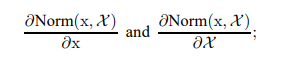
**Image Source:** [(Ioffe and Szegedy 2015)](https://arxiv.org/abs/1502.03167)

However, computing the whitening factors by this approach is quite an expensive task considering the amount of data points in the entire training set after every parameter update.

## Normalization via Mini-Batch Statistics

Since full whitening of every layers input is a very expensive task and also not dfferentiable everywhere, the [paper](https://arxiv.org/abs/1502.03167) suggests 2 simplifications - 

### 1. Normalize each scalar feature independently to have zero mean and unit variance.
For a layer with multidimensional inputs: **x = (x<sub>1</sub>, x<sub>2</sub>, ..., x<sub>d</sub>)** eacg dimension should be normalized as per - 
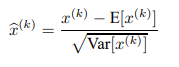
**Image Source:** [(Ioffe and Szegedy 2015)](https://arxiv.org/abs/1502.03167)
    
where the expectation and variance are computed over the entire training dataset. Now, it is very much possible that the normalizaion could alter what the layer represents. This is addressed by ensuring that the "*transformation inserted in the network can represent the identity transformation*" and the layer retains its representational power. To accomplish this, 2 new learnable parameters are added for each activation **x<sup>(k)</sup>**. The parameters are **γ<sup>(k)</sup>** (gamma) and **β<sup>(k)</sup>** (beta) which scale and shift the normalized values respectively.

**y<sup>(k)</sup> = γ<sup>(k)</sup>  $\hat{x}$ <sup>(k)</sup> + β<sup>(k)</sup>**

**γ<sup>(k)</sup>** and **β<sup>(k)</sup>** are learned along with the other parameters during training and help to restore the representational power of the network. 

By setting - <br>
**γ<sup>(k)</sup> = $\sqrt{Var[x(k)]}$** , and <br>
**β<sup>(k)</sup> = E[x<sup>(k)</sup>]**

the original activations could be recovered. This would allow the netwrok to undo the batch normalization and simply act as an **identity transofrmation** function. *The identity transform is a data transformation that copies the source data into the destination data without change*.

### 2. Use of Mini-batch Statistics

*Each mini-batch produces estimates of the mean and variance of each activation.*  This would allow the statistics used for normalization to participate in the gradient backpropagation. Considering a mini-batch of size **m**, B = {(x<sub>1</sub>, x<sub>2</sub>, ..., x<sub>m</sub>)}, and since normalization is applied to each activation independently, let the corresponding normalized values be {($\hat{x}$<sub>1</sub>, $\hat{x}$<sub>2</sub>, ..., $\hat{x}$<sub>m</sub>)} and the corresponsing linear transformations be {(y<sub>1</sub>, y<sub>2</sub>, ..., y<sub>m</sub>)}, then

**BN<sub>γ,β</sub> : x<sub>1...m</sub> : y<sub>1...m</sub>** is known as the **Batch Normalizing Transform**.

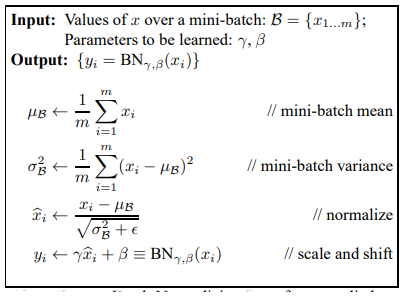
**Image Source:** [Algorithm 1: Batch Normalizing Transform, applied to activation x over a mini-batch](https://arxiv.org/abs/1502.03167)

**ε** is a constant added to the mini-batch variance for numerical stability of the BatchNorm.

- The scaled and shifted values are passed to the subsequent network layers.

- Each normalized activation $\hat{x}$ <sup>(k)</sup> is an input to a sub-network composed of linear transformation. **y<sup>(k)</sup> = γ<sup>(k)</sup>  $\hat{x}$ <sup>(k)</sup> + β<sup>(k)</sup>**. The introduction of normalized inputs accelerates the training of the sub-network and consequently the whole network.

- The gradient of the loss is back propagated during training. The gradients are computed through the parameters of batch normalization. The BatchNorm transform if differentiable and introduces normalized activations into the network. This ensures that the hidden layers can continue to learn on input distributions with less covariate shift and thus accelerate training. The learned affine transform applied to these normalized activations allows the BN transform to represent the identity transformation and preserves the network capacity.


## Training and Inference with Batch Norm Networks

### Training/Validation

After Batch Norm is applied the activations of a hidden layer, the next layer receives **BN(x)** and input instead of **x**. Once the model/network is completely trained, the follwoing normalization is applied - 

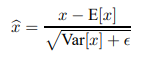
**Image Source:** [(Ioffe and Szegedy 2015)](https://arxiv.org/abs/1502.03167)

using the entire population statistic to ensure that the output is solely dependent on the input alone. The model accuracy is tracked using **moving averages** during the training/validation phase. iDuring the validation plase, the predictions are made on the validation set to estimate the validation error. During this phase, we do not have a population average (the averages are still changing as the model trains), so a running average is employed to calculate the batch norm parameters to calculate performance on validation set.

As mentioned in the BatchNormalization [code comments in the keras implementation](https://github.com/keras-team/keras/blob/v2.6.0/keras/layers/normalization/batch_normalization.py#L52-L57) - ***During inference*** *(i.e. when using `evaluate()` or `predict()`) or when calling the layer/model with the argument `training=False` (which is the default), the layer normalizes its output using a moving average of the mean and standard deviation of the batches it has seen during training.<br>
That is to say, it returns `γ * (batch - self.moving_mean) / sqrt(self.moving_var + epsilon) + β`. 

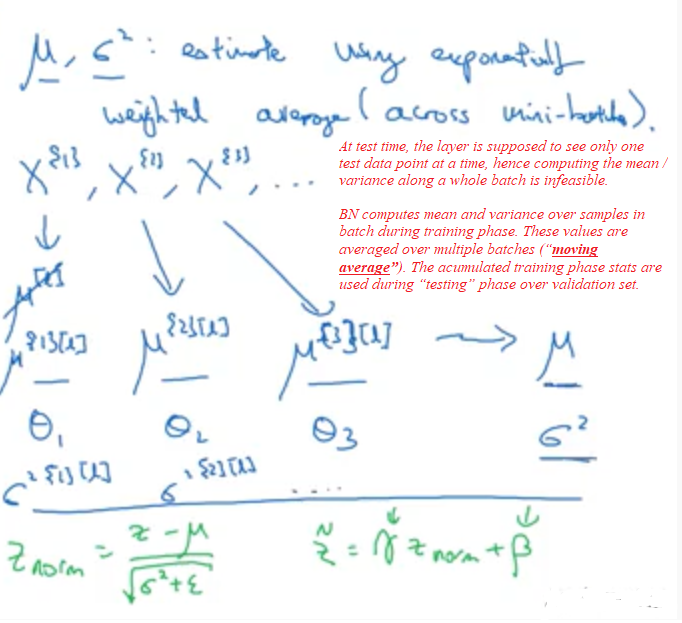
**Image Source:** [Batch Norm At Test Time - Andrew Ng](https://youtu.be/5qefnAek8OA?t=292)

### Inference

At the inference time, the mean and variance are fixed. The normalization applied is just a linear transformation applied to each activation, and composed further by the scaling factor **γ** and shifted by **β**.

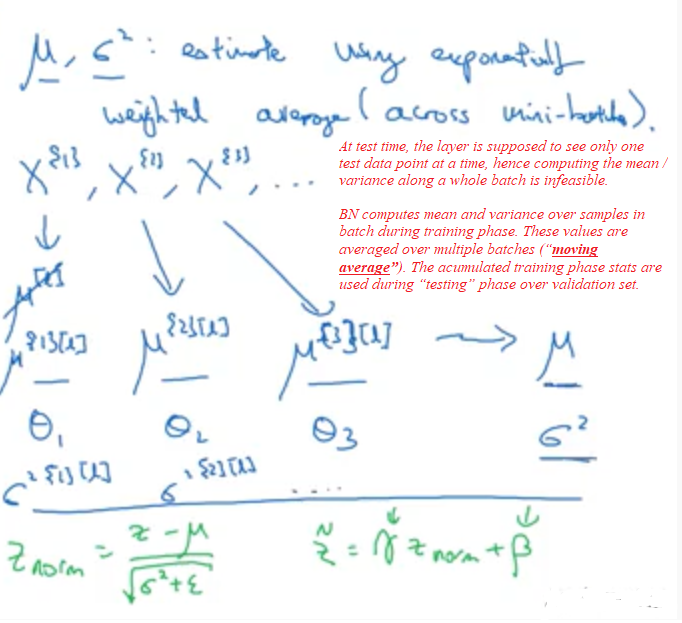
**Image Source:** [Algorithm 2: Training a Batch-Normalized Network](https://arxiv.org/abs/1502.03167)

##  Batch-Normalized Convolutional Network

Batch Norm can be applied to any activation in a neural network. However, the main focus in on transformations apply `affine transformation followed by adding element wise non-linearity`. **z = (Wu + b)** where, **W**, **b** are learned parameters of the model while **g(.)** is the non-linearity such as ReLU or sigmoid.

Batch Norm is added immediately before the non-linear transformation to normalize **z = (Wu + b)** which is likely to be more **`symmetric`** and **`non-sparse distribution`** that is more **`gaussian`** in nature compared to `u` alone which is the output of another non-linearity.

After normalization, the effect of bias will be cancelled by the parameter **β**. So the updated formulation would become - 
**z = g(BN(Wu))** which is applied independently through each dimension of **x = Wu**, with separate pairs of learned parameters **γ<sup>(k)</sup>**  and **β<sup>(k)</sup>** per dimension.

To ensure the Batch Norm ensured the `convolutional property`, different elements of the same feature map at different locations are all normalized the same way. `All activations are jointly nomalized in a mini-batch over all locations`.


## Batch Normalization enables higher learning rates

Traditionally, higher learning rates are known to either result in the `exploding` or `vanishing` gradient problem. It may even cause the network to get stuck in a poor local minima.

- Batch Norm prevents the network from aplifying small changes to the parameters and prevents the training from getting stuck in saturated regions of non-linearities. 

- Batch Norm makes training more resilient to the parameter scale. Larger learning rate may increase the parameter scale which could ampligy during back propagation eventually leading to model explosion. BN makes the back propagation through a layer remain unaffected by the scale increases and consequently stabilize the training and parameter growth.<br>
    **BN(Wu) = BN((aW) u)** --> the scale of the parameters does not affect the layers Jacobian.
    

## Batch Normalization as Regularizer

Batch Norm introduces some randomness in the training phase because we compute the mean and variance over a mini-batch. The normalization in again  amplified by the learned parameters **γ**  and **β**. This causes the network to see a sightly different variation of the same input depending on the given mini-batch. This will inturn force the model to ignore noise. **The regularization effect on batch normalization is a side effect**. 

Since the mean and standard deviation fluctuate over different mini-batches, these values act as the sources of some amount of noise that the layer has to learn to ignore and be robuts to these variations in the input. And it is already known fact that adding noise to the gradient improves accuracy of the model as presented in the paper - [Adding Gradient Noise Improves Learning for Very Deep Networks](https://arxiv.org/abs/1511.06807).


# Frequently Asked Questions

### 1. Why Batch Norm is important ?

To get a sense for why batch normalization is important, consider a neural network with two hidden layers, **h1** and **h2**, and inputs **x**, so that the input to h2 depends on the activation of h1. However, during SGD, the parameters of both hidden layers are changing , due to which the distribution of the activations of **h1** are constantly changing (mean, standard deviation, etc). This makes it difficult to accurately optimize the weights of **h2**, since the weights are having to continuously react and update to the new distribution of inputs from the activations of **h1**.

Batch Norm aims to reduce this "**covariance shift**" in the inputs to **h2** and ensure training can be faster and smoother. BatchNorm accomplishes this by standardizing each hidden layer activations to ensure they always represent the input distribution and are fixed with **zero mean** and **unit variance**. The inputs to the subsequent hidden layers will  have the same distribution.

### 2. What does the notion of  Network Capacity refer to ?

**Network Capacity** refers to the `expressive power` of a model - **how complicated a pattern or relationship a model can express**.

The process of standardization in Batch Norm throws away a lot of information about the previous layer, which may lead to a `decreased ability for the model to learn complicated interactions` - this is the notion of capacity being referred to. BatchNorm resolves this by adding two learnable parameters, **γ** and **β**, which allow to `add back` some information of the previous layer: **y<sup>1</sup> = γ $\hat{a}$<sup>1</sup> + β**

The y<sup>1</sup> is now used as input for h2. Note that when `γ=SD(a)`, and `β=empirical mean(a)`, we recover the original inputs, which is the identity transform the original paper was referring to. And, when `γ=1,β=0`, we again have our completely standardized inputs. This way, we allow for a balance between reducing the effects of covariance shift, while simultaneously maintaining the expressiveness of our neural network.


### 3. What are the Vanishing Gradient & Exploding Gradient problems solved by Batch Norm ?

**Vanishing Gradient -**<br>
The vanishing gradients problem is an unstable behavior that is often encountered when training deep neural networks, and occurs when a neural network is unable to efficiently backpropagate useful gradient information to weights towards the start (input) of the network. This happens because activation functions gradually diminish the signal as it backpropagates throughout the network. As a result, the layers near the input of the model remain relatively unchanged and provide little value, restricting the model capacity and consequently its true predictive power. Hence, the optimizer can only optimize the model only with the weights it can access, and therefore remain stagnant with no improvement since the layers at the beginning of the network are not being utilized.

When the input distribution changes, the inner layers will get smaller gradient updates due to the activation functions not being utilized efficiently. Batch normalization helps make sure that the signal is heard and not diminished by shifting distributions from the end to the beginning of the network during backpropagation. Batch Norm prevents the network from aplifying small changes to the parameters and prevents the training from getting stuck in saturated regions of non-linearities. 

**Exploding Gradient -**<br>
The explosive gradients problem occurs when large errored gradients sequentially accumulate and result in large, unstable, pendulum-like updates on the neural network weights during training. Batch Norm is known to smooth out the optimization landscape [(Santurkar et al. 2018)](https://arxiv.org/abs/1805.11604), it gets rid of the extreme gradients that accumulate, leading to the elimination of the major weight fluctuations that result from gradient build-up and consequently stabilizes the learning.

### 4. Should BatchNorm come before or after Non-linearity?

The paper says to apply the batch norm transformation before the nonlinearity. It is described as "*We add the BN transform immediately before the nonlinearity, by normalizing x = Wu + b*".

[Tensorflow implementation](https://github.com/keras-team/keras-applications/blob/master/keras_applications/inception_v3.py#L73-L80) of the InceptionV3 model applies BN before the nonlinear layer as described in the paper.

However, in practice it works better if **batch morm is applied after the nonlinear layer**. The reason being, the point of adding a BatchNorm layer is to make the data zero mean and unit variance. Applying nonlinearity (like ReLU) after the BN defeats the purpose because the output of nonlinearity is input to another layer.

From a **statistics point** of view BN before activation does not make sense. BN is normalizing the distribution of features coming out of a convolution, some these features might be `negative` which will be truncated by a non-linearity like ReLU. If you normalize before activation you are including these negative values in the normalization immediately before culling them from the feature space. **`BN after activation will normalize the positive features without statistically biasing them with features that do not make it through to the next convolutional layer`**. [Ref: BatchNorm Position](https://forums.fast.ai/t/questions-about-batch-normalization/230/9)

### 5.  In Step 10 of Algorithm 2, Where did that m/(m-1) come from?

Algorithm 1, does not take into account the population statistics. Rather, it takes the mini-batch statistics. Sample statistics are calculated differently in order to make them equal in expectation to the population statistics and we want our mini-batch statistics to be unbiased to population statistics. 

The difference between the variance of the population versus the sample/mini-batch variance is that **σ is normalized by m** and **s is normalized by (m-1)**. Conceptually, the reason why we use (m-1) is that we estimate the mean (in the form of x bar - the sample mean) to be centered, then the spread of the points (i.e., variance) has be a bit larger. In this case, it’s going to be precisely **m/(m-1)** larger. So, when we assign

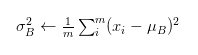

under Algorithm 1, you’re underestimating the true variance of the dataset, which is why Algorithm 2, line 10 requires an additional term:

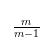

**Ref:** [Batch Normalization — What the hey?](https://gab41.lab41.org/batch-normalization-what-the-hey-d480039a9e3b)

## Further Reading

[1] [How Does Batch Normalization Help Optimization? (Santurkar et al. 2018)](https://arxiv.org/abs/1805.11604)

[2] [Understanding the Disharmony between Dropout and Batch Normalization by Variance Shift (Li et al. 2018)](https://arxiv.org/abs/1801.05134)

[3] [Understanding the gradient flow through the BatchNorm layer](https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html) - A very good and informative to understanding the backward pass through Batch Normalization Layer.

## References

[1] [Batch Normalization - Accelerate Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)

[2] [Why is Batch Norm preserving the capacity of a network?](https://stats.stackexchange.com/questions/412990/why-is-batch-normalization-preserving-the-capacity-of-a-network)

[3] [Batch Normalization FAQ](https://forums.fast.ai/t/questions-about-batch-normalization/230/9)

[4] [Batch Normalization - Greatest Break Through](https://towardsdatascience.com/batch-normalization-the-greatest-breakthrough-in-deep-learning-77e64909d81d)

[5] [Deeper Understanding of Batch Normalization](https://medium.com/@SeoJaeDuk/deeper-understanding-of-batch-normalization-with-interactive-code-in-tensorflow-manual-back-1d50d6903d35)

[6] [Andrej Karpathy’s lecture on BatchNorm](https://youtu.be/gYpoJMlgyXA?list=PLkt2uSq6rBVctENoVBg1TpCC7OQi31AlC&t=3079)

[7] [On The Perils of Batch Norm](https://www.alexirpan.com/2017/04/26/perils-batch-norm.html)

[8] [Batch Normalization — What the hey?](https://gab41.lab41.org/batch-normalization-what-the-hey-d480039a9e3b)

[9] [Batch Norm By Andrew Ng - Fitting BatchNorm into a NN](https://www.youtube.com/watch?v=em6dfRxYkYU&ab_channel=DeepLearningAI)

[10] [Batch Norm By Andrew Ng - Why BN Works?](https://www.youtube.com/watch?v=nUUqwaxLnWs&ab_channel=DeepLearningAI)

[11] [Batch Norm By Andrew Ng - BN during Inference](https://www.youtube.com/watch?v=5qefnAek8OA&ab_channel=DeepLearningAI)